# Stress Prediction for Nurses
## AAI 530 Group 5
### Deepti Pamula, Prema Mallikarjunan, Tommy Poole

This project uses machine learning and deep learning techniques to analyze the data found at https://www.kaggle.com/datasets/priyankraval/nurse-stress-prediction-wearable-sensors?resource=download gathered from nurses during the COVID-19 pandemic in a hospital settings, capturing real-world stress factors in a healthcare environment.

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import keras

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, recall_score, make_scorer, precision_score, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GroupShuffleSplit, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [2]:
# Set seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

In [3]:
# Connect data from colab
# Mount google drive to access data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Access csv data file from mounted google drive
csv_path = '/content/drive/MyDrive/AAI-530-IoT-Group5/Colab/merged_data.csv'

# Create a dataframe of the csv data
df2 = pd.read_csv(csv_path)

<ipython-input-4-d076502aae57>:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(csv_path)


In [5]:
# Convert problematic columns to a specific data type
df2["id"] = df2["id"].astype(str)  # Convert to string
df2["label"] = df2["label"].astype("int32")

In [ ]:
"""
# Use for local machine data import
# Import the data
df2 = pd.read_csv("merged_data.csv", low_memory=False, parse_dates=['datetime'])

# Convert problematic columns to a specific data type
df2["id"] = df2["id"].astype(str)  # Convert to string
df2["label"] = df2["label"].astype("int32")

# Exploratory Data Analysis

In [ ]:
# Review the top of the dataframe
df2.head(10)

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2
5,-9.0,-57.0,-32.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.156250112,2
6,9.0,-68.0,-2.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.187500032,2
7,-6.0,-74.0,17.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.218749952,2
8,-1.0,-68.0,-19.0,6.805877,99.43,31.17,15,2020-07-08 14:03:00.249999872,2
9,-9.0,-63.0,-37.0,6.805877,99.43,31.17,15,2020-07-08 14:03:00.281250048,2


In [ ]:
# Review the end of the dataframe
df2.tail(10)

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
11509041,-32.0,-43.0,56.0,3.398877,88.37,33.77,F5,2020-07-23 17:28:59.718749952,2
11509042,-16.0,-52.0,52.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.750000128,2
11509043,-47.0,-78.0,5.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.781250048,2
11509044,-45.0,-77.0,-24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.812499968,2
11509045,-51.0,-77.0,23.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.843749888,2
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2
11509050,-22.0,-24.0,29.0,3.374543,88.33,33.75,F5,2020-07-23 17:29:00.000000000,2


In [ ]:
print(df2.columns)

Index(['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id', 'datetime', 'label'], dtype='object')


In [ ]:
# Review the datatypes
print(df2.dtypes)

X           float64
Y           float64
Z           float64
EDA         float64
HR          float64
TEMP        float64
id           object
datetime     object
label         int32
dtype: object


In [ ]:
# Check for missing data
df2.isna().sum()

,0
X,0
Y,0
Z,0
EDA,0
HR,0
TEMP,0
id,0
datetime,0
label,0


## Dataset Nine Columns Description
### (From Kaggle Project Description)

**X, Y, Z:**
Description: Numerical values representing orientation data.
Unique Entries: Each column has 256 unique values.

**EDA (Electrodermal Activity):**
Description: Continuous numerical values measuring electrodermal activity.
Unique Entries: Contains 274,452 unique numerical values.

**HR (Heart Rate):**
Description: Continuous numerical values representing heart rate measurements.
Unique Entries: Comprises 6,268 distinct numerical values.

**TEMP (Temperature):**
Description: Continuous numerical values denoting temperature readings.
Unique Entries: Contains 599 unique numerical values.

**id:**
Description: Categorical data serving as identifiers for specific subjects or entities.
Unique Entries: Consists of 18 distinct categorical entries.

**datetime:**
Description: Object type encompassing a wide range of date and time entries.
Unique Entries: Holds approximately 10.6 million unique date and time values.

**label:**
Description: Categorical data representing different states or classes.

Unique Entries: Contains three unique categorical values.
Each column in this dataset offers distinct information. The orientation data (X, Y, Z) seemingly represents spatial or directional measurements. Electrodermal activity (EDA), heart rate (HR), and temperature (TEMP) columns provide continuous physiological measurements. The 'id' column serves as a categorical identifier, while 'datetime' indicates timestamps. Lastly, the 'label' column presents categorical classifications.

Generating Histograms: 100%|██████████| 7/7 [07:44<00:00, 66.35s/it]


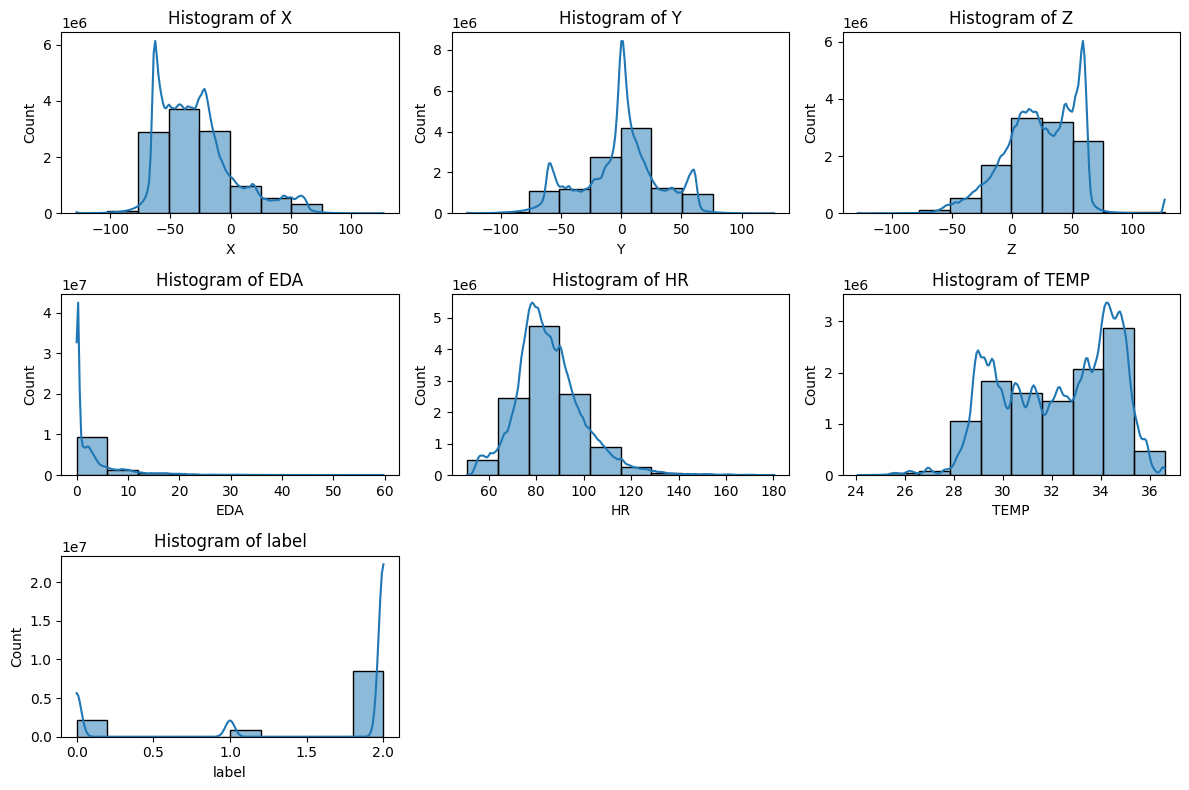

In [ ]:
# Visualize the data as histograms
plt.figure(figsize=(12, 8))
columns = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'label']

# Use tqdm to wrap the loop for progress tracking
for i, col in enumerate(tqdm(columns, desc="Generating Histograms"), 1):
    plt.subplot(3, 3, i)
    sns.histplot(df2[col], kde=True, bins=10)
    plt.title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [ ]:
# Set datetime as the index
df2.set_index('datetime', inplace=True)

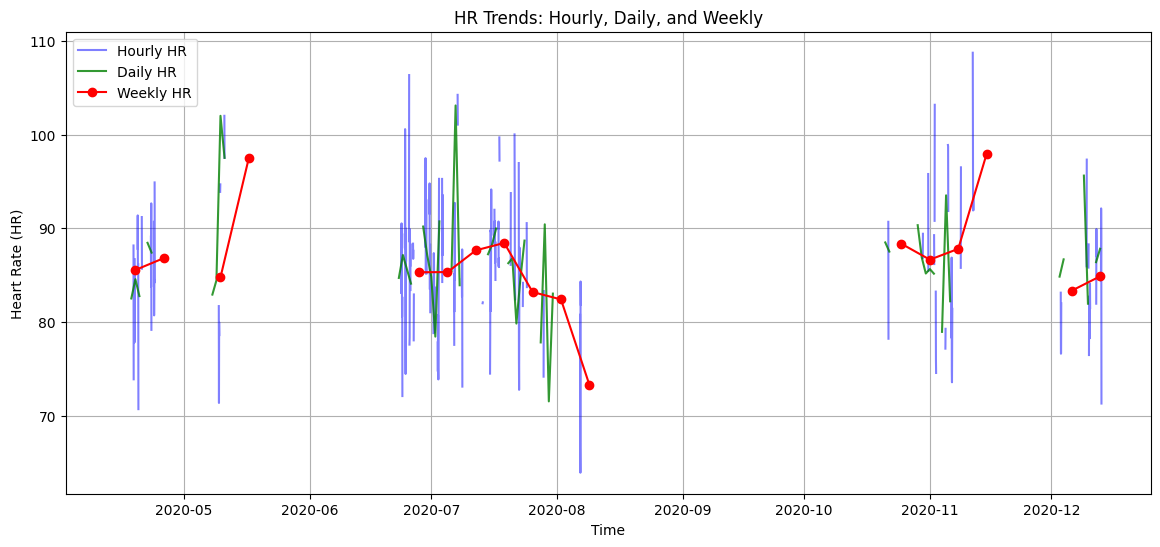

In [ ]:
# Add hourly, daily, weekly attributes to capture trends for heartrate
hr_hourly = df2['HR'].resample('h').mean()
hr_daily = df2['HR'].resample('D').mean()
hr_weekly = df2['HR'].resample('W').mean()
data_hourly = df2[['X', 'Y', 'Z', 'EDA', 'HR']].resample('h').mean()

# Visualize the data to look for trends
plt.figure(figsize=(14, 6))

# Plot all hourly, daily and weekly trends
plt.plot(hr_hourly, linestyle='-', alpha=0.5, color='blue', label='Hourly HR')
plt.plot(hr_daily, linestyle='-', alpha=0.8, color='green', label='Daily HR')
plt.plot(hr_weekly, linestyle='-', alpha=1.0, color='red', marker='o', label='Weekly HR')
plt.xlabel("Time")
plt.ylabel("Heart Rate (HR)")
plt.title("HR Trends: Hourly, Daily, and Weekly")
plt.legend()
plt.grid(True)

plt.show()

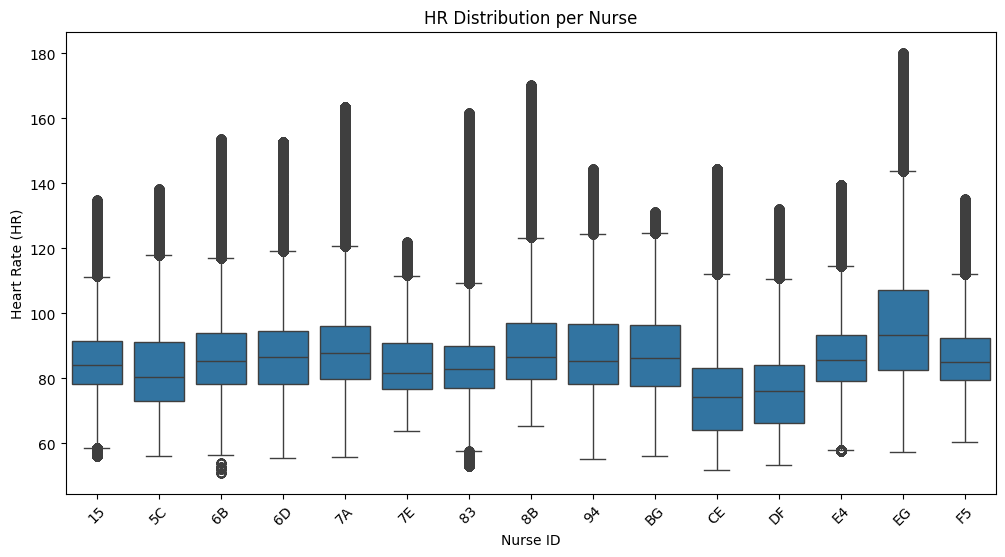

In [ ]:
# Check heartrate for trends in boxplot format
plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='HR', data=df2)
plt.title('HR Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('Heart Rate (HR)')
plt.xticks(rotation=45)
plt.show()


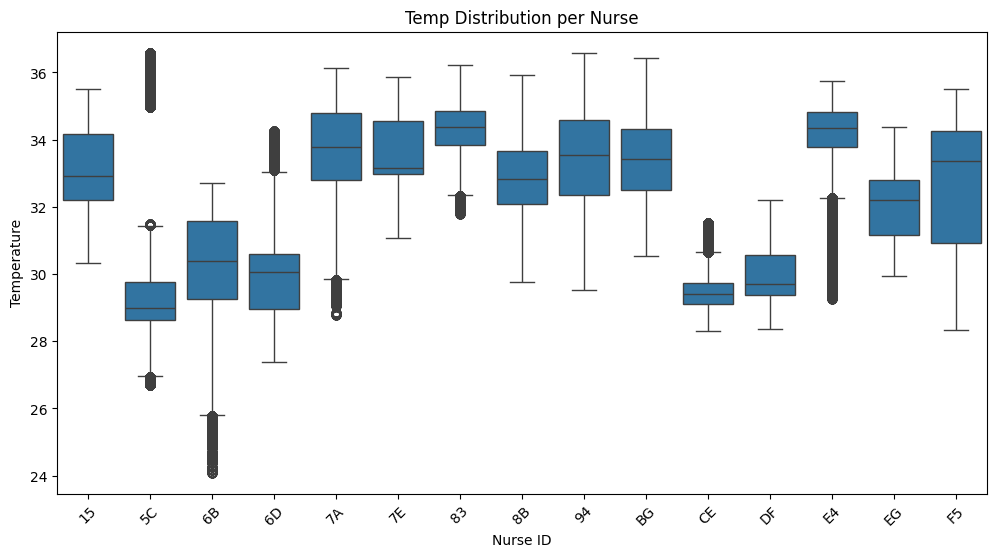

In [ ]:
# Check the temperature field in boxplot format to check for trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='TEMP', data=df2)
plt.title('Temp Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.show()


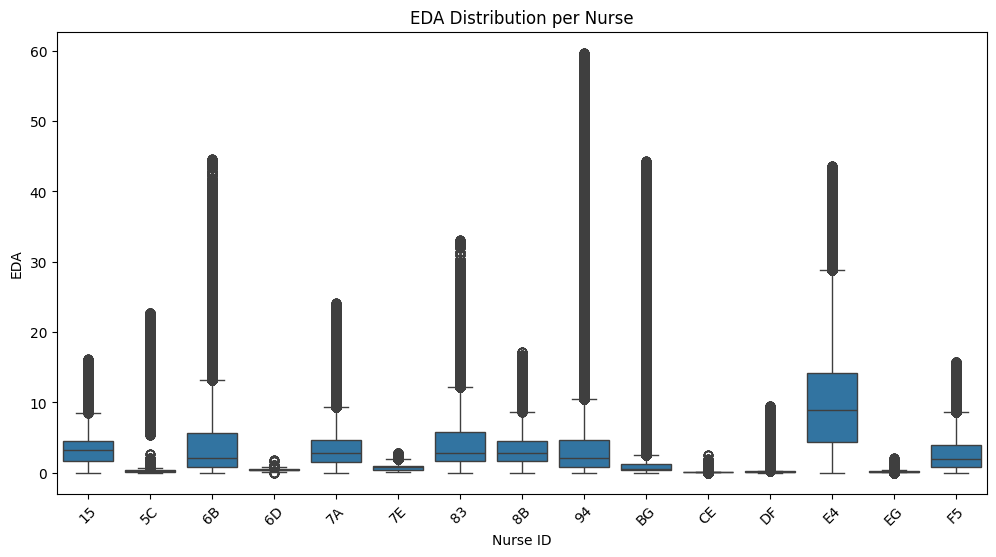

In [ ]:
# Plot the EDA in boxplot to explore trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='EDA', data=df2)
plt.title('EDA Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('EDA')
plt.xticks(rotation=45)
plt.show()

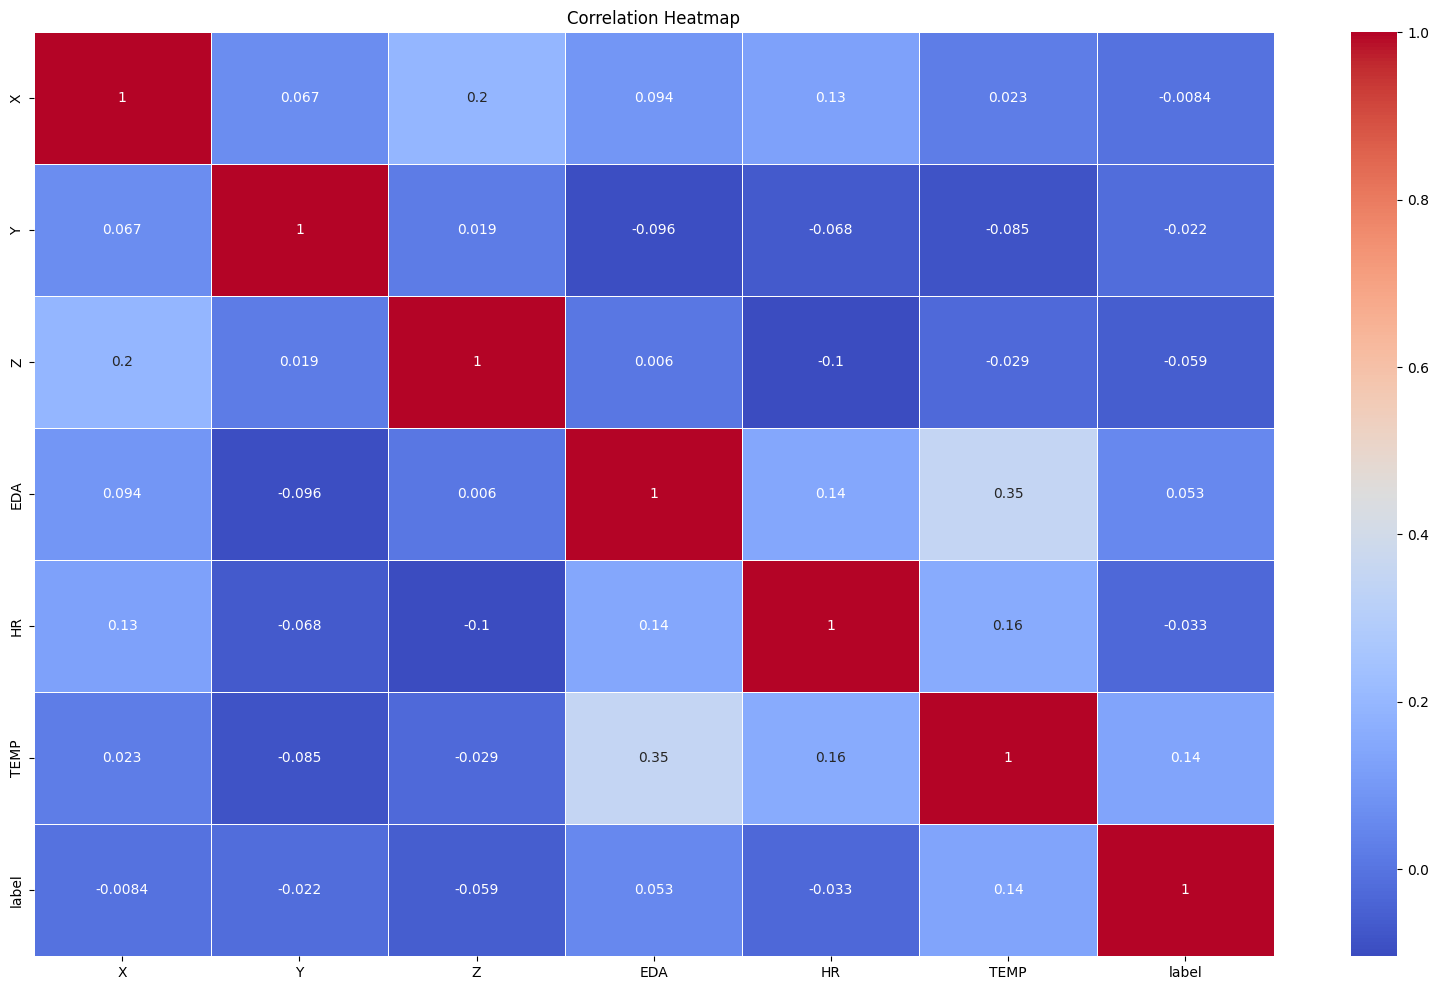

In [ ]:
plt.figure(figsize=(20,12))
sns.heatmap(df2.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

# Models

## Random Forest Machine Learning Algorithm

Data preprocessing for stress prediction.

In [ ]:
# Reset the index
df2 = df2.reset_index()

In [ ]:
# Convert datetime to datetime object
df2["datetime"] = pd.to_datetime(df2["datetime"])

In [ ]:
# Convert datetime into more meaningful units for Random Forest Classifier
df2["day_of_week"] = df2["datetime"].dt.dayofweek
df2["month"] = df2["datetime"].dt.month
df2["day_of_month"] = df2["datetime"].dt.day

In [ ]:
# Confirm column creation for debugging
print(df2.columns)

Index(['level_0', 'datetime', 'index', 'X', 'Y', 'Z', 'EDA', 'HR', 'TEMP',
       'id', 'label', 'day_of_week', 'month', 'day_of_month', 'id_encoded',
       'label_0', 'label_1', 'label_2'],
      dtype='object')


In [ ]:
# Label Encoding for 'id'
le = LabelEncoder()
df2['id_encoded'] = le.fit_transform(df2['id'])

# One-Hot Encoding for 'label'
ohe = OneHotEncoder(sparse_output=False)
label_encoded = ohe.fit_transform(df2[['label']])
label_columns = ohe.get_feature_names_out(['label'])
df2[label_columns] = label_encoded

In [ ]:
features = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id_encoded', 'day_of_month', 'day_of_week', 'month']
X = df2[features]
y = df2['label'] # Using the columns of data above to predict the label column

In [ ]:
# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the number of trees (reduced to 10 for faster execution)
n_estimators = 10

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

# Fit the model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [ ]:
y_pred = rf_classifier.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    432097
           1       1.00      1.00      1.00    160853
           2       1.00      1.00      1.00   1708861

    accuracy                           1.00   2301811
   macro avg       1.00      1.00      1.00   2301811
weighted avg       1.00      1.00      1.00   2301811


Confusion Matrix:
[[ 432037       9      51]
 [     53  160755      45]
 [    120      46 1708695]]


In [ ]:
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_classifier.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
        feature  importance
7  day_of_month    0.205765
3           EDA    0.188951
6    id_encoded    0.169030
5          TEMP    0.140899
8   day_of_week    0.107140
9         month    0.093080
4            HR    0.032644
2             Z    0.026582
1             Y    0.020844
0             X    0.015064



## Model 2 - Deep Learning Long Short Term Memory (LSTM) Model


1. Time series prediction, can we predict stress level 15 minutes from now using

In [8]:
# Take a subset of the total data for faster processing
subset_size= int(len(df2) * 0.001) # Take 1000 rows of 1,000,000 total

# Take random data subset
df_subset = df2.iloc[:subset_size]

# Split data subset 80/20 for train/validation
split_pos = int(len(df_subset) * 0.8)
train_df = df_subset.iloc[:split_pos]
val_df = df_subset.iloc[split_pos:]

In [9]:
# Reset the indices
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [10]:
seq_arrays = []
seq_labs = []

In [11]:
# Define sequence length and prediction horizon
seq_length = 60  # Use last 60 minutes of data
ph = 15  # Predict 15 minutes ahead

# Features to use for prediction
feat_cols = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP']

scaler = StandardScaler()
train_df[feat_cols] = scaler.fit_transform(train_df[feat_cols])  # Fit & transform on train data
val_df[feat_cols] = scaler.transform(val_df[feat_cols])


# Convert dataset into sequences
stress_values = train_df[feat_cols].values
seq_arrays, seq_labs = [], []

for i in range(len(stress_values) - seq_length - ph):
    # Input sequence for the past 60 minutes
    seq = stress_values[i: i + seq_length]

    # Output (stress level 15 minutes ahead)
    label = stress_values[i + seq_length + ph - 1][0]

    seq_arrays.append(seq)
    seq_labs.append(label)

# Convert lists to numpy arrays (ensure compatibility with TensorFlow)
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)

print(f"Sequence shape: {seq_arrays.shape}")  # Should be (num_samples, 60, num_features)
print(f"Labels shape: {seq_labs.shape}")  # Should be (num_samples,)


Sequence shape: (9132, 60, 6)
Labels shape: (9132,)


In [12]:
# For code hygeine, confirm shape is as intended
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [13]:
seq_arrays.shape

(9132, 60, 6)

In [14]:
# Define path to save model
model_path = 'LSTM_model1.keras'

# Build the network
nb_features = seq_arrays.shape[2]
nb_out = 1

model = Sequential()

# Add first LSTM layer
model.add(LSTM(
         input_shape=(seq_arrays.shape[1], nb_features),
         units=10,
         return_sequences=True))
model.add(Dropout(0.2))

# Add second LSTM layer
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

# Fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# List all data in history
print(history.history.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 10)              │             680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          12,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,931 (50.51 KB)

 Trainable params: 12,931 (50.51 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 - 9s - 479ms/step - loss: 0.4695 - mse: 0.4695 - val_loss: 0.1301 - val_mse: 0.1301
Epoch 2/100
18/18 - 5s - 255ms/step - loss: 0.3284 - mse: 0.3284 - val_loss: 0.0651 - val_mse: 0.0651
Epoch 3/100
18/18 - 7s - 376ms/step - loss: 0.3153 - mse: 0.3153 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 4/100
18/18 - 3s - 186ms/step - loss: 0.3057 - mse: 0.3057 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 5/100
18/18 - 3s - 177ms/step - loss: 0.2991 - mse: 0.2991 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 6/100
18/18 - 7s - 385ms/step - loss: 0.2923 - mse: 0.2923 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 7/100
18/18 - 3s - 178ms/step - loss: 0.2790 - mse: 0.2790 - val_loss: 0.0512 - val_mse: 0.0512
Epoch 8/100
18/18 - 6s - 326ms/step - loss: 0.2736 - mse: 0.2736 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 9/100
18/18 - 6s - 352ms/step - loss: 0.2521 - mse: 0.2521 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 10/100
18/18 - 3s - 175ms/step - loss: 0.2369 - mse: 0.2369 - val_loss:

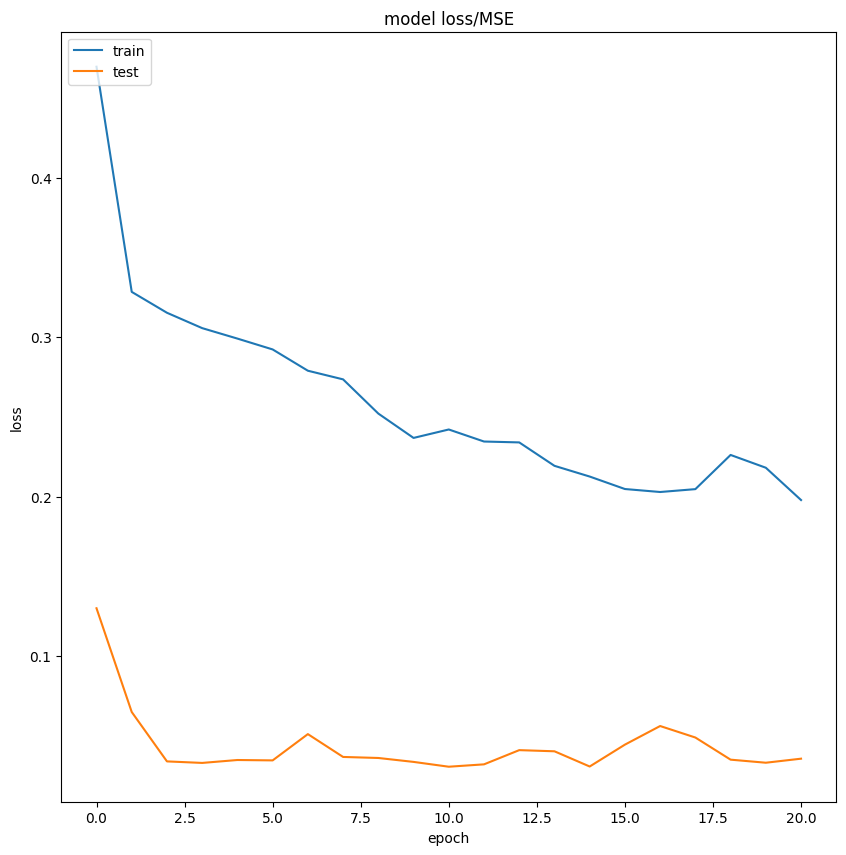

In [15]:
# Summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

In [17]:
val_arrays = []
val_labs = []

# Create list of stress readings starting with a minimum of two readings
seq_length = 30   # LSTM requires sequences of length 30
ph = 5            # Predictive horizon (how many steps ahead we want to predict)

 # Choosing all relevant features
feat_cols = ['X', 'Y', 'Z', 'HR', 'EDA', 'TEMP']


# Extract values from your validation set
stress_values_val = val_df[feat_cols].values
labels_val = val_df['label'].values  # Keep labels separately


# Create sequences starting with seq length
for i in range(len(stress_values_val) - seq_length - ph):
    # Extract sequence of past `seq_length` feature readings
    stress_sequence = stress_values_val[i: i + seq_length]

    # Append sequence to val_arrays
    val_arrays.append(stress_sequence)

    # The label is at `seq_length + ph - 1`
    gap_label = labels_val[i + seq_length + ph - 1]
    val_labs.append(gap_label)

# Convert lists to NumPy arrays
val_arrays = np.array(val_arrays, dtype=np.float32)  # Shape: (samples, seq_length, num_features)
val_labs = np.array(val_labs, dtype=np.float32)  # Shape: (samples, )

71/71 - 1s - 8ms/step - loss: 8.4275 - mse: 8.4275

MSE: 8.427472114562988
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


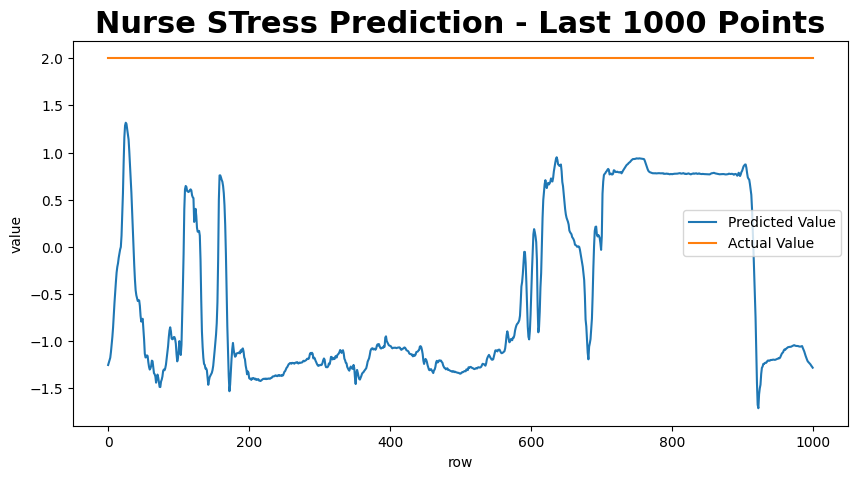

In [19]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-1000:], label = 'Predicted Value')
plt.plot(y_true_test[-1000:], label = 'Actual Value')
plt.title('Nurse STress Prediction - Last 1000 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")